In [1]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
!pip install scikit-learn

In [49]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [50]:
def get_historical_data(symbol, days):
    url = f"https://api.coingecko.com/api/v3/coins/{symbol}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'
    }
    response = requests.get(url, params=params)
    data = response.json()
    prices = data['prices']
    timestamps, values = zip(*prices)
    return np.array(timestamps), np.array(values)

In [51]:
def preprocess_data(values):
    scaler = MinMaxScaler(feature_range=(0, 1))
    values_scaled = scaler.fit_transform(values.reshape(-1, 1))
    return values_scaled, scaler


In [52]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)


In [66]:
def build_lstm_model(sequence_length):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length-1, 1)))  # Adjusted input shape
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [67]:
def train_lstm_model(model, X_train, y_train, epochs, batch_size):
    print("Shapes before training:")
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    
    print("Shapes after training:")
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)


In [68]:
def plot_results(actual, predicted, scaler):
    actual_prices = scaler.inverse_transform(actual.reshape(-1, 1))
    predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    plt.plot(actual_prices, label='Actual Prices', color='blue')
    plt.plot(predicted_prices, label='Predicted Prices', color='red')
    plt.title('Cryptocurrency Price Prediction using LSTM')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

Shapes before training:
X_train shape: (285, 9, 1)
y_train shape: (285, 1)
Epoch 1/10
9/9 - 1s - loss: 0.1211 - 1s/epoch - 131ms/step
Epoch 2/10
9/9 - 0s - loss: 0.0558 - 32ms/epoch - 4ms/step
Epoch 3/10
9/9 - 0s - loss: 0.0114 - 34ms/epoch - 4ms/step
Epoch 4/10
9/9 - 0s - loss: 0.0079 - 32ms/epoch - 4ms/step
Epoch 5/10
9/9 - 0s - loss: 0.0044 - 29ms/epoch - 3ms/step
Epoch 6/10
9/9 - 0s - loss: 0.0042 - 34ms/epoch - 4ms/step
Epoch 7/10
9/9 - 0s - loss: 0.0034 - 31ms/epoch - 3ms/step
Epoch 8/10
9/9 - 0s - loss: 0.0031 - 30ms/epoch - 3ms/step
Epoch 9/10
9/9 - 0s - loss: 0.0028 - 28ms/epoch - 3ms/step
Epoch 10/10
9/9 - 0s - loss: 0.0026 - 35ms/epoch - 4ms/step
Shapes after training:
X_train shape: (285, 9, 1)
y_train shape: (285, 1)
3/3 [==============================] - 0s 2ms/step
Mean Squared Error: 0.0031622053381467844


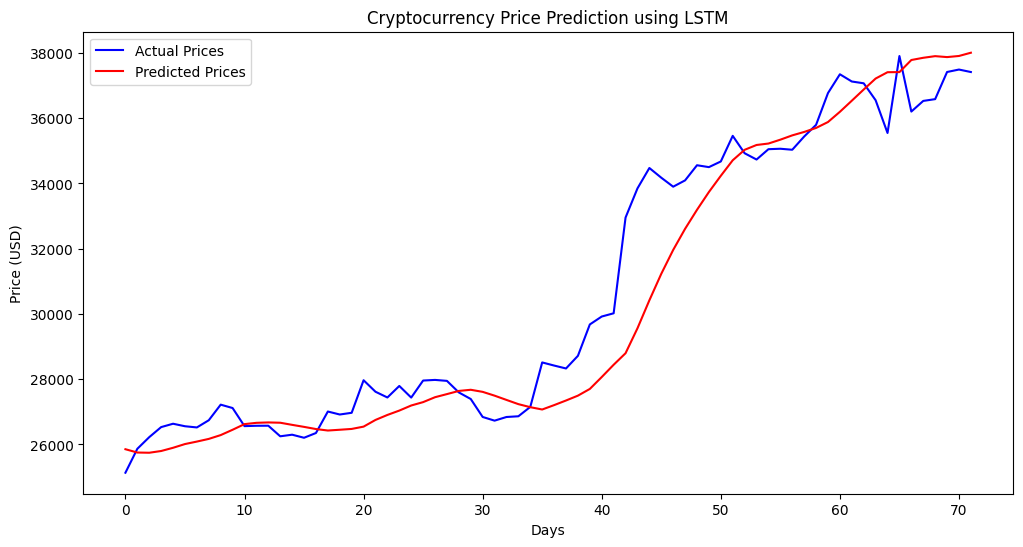

In [69]:
def main():
    symbol = 'bitcoin'
    days = 365
    timestamps, values = get_historical_data(symbol, days)

    values_scaled, scaler = preprocess_data(values)

    sequence_length = 10  # Ensure that this matches the sequence length used when creating sequences
    sequences = create_sequences(values_scaled, sequence_length)

    X = sequences[:, :-1]
    y = sequences[:, -1]

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Ensure correct reshaping

    # Split data into training and testing sets
    split_ratio = 0.8
    split_index = int(split_ratio * len(sequences))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Build and train the LSTM model
    model = build_lstm_model(sequence_length)

    # Reshape X_train to match the model input shape just before training
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Reshape y_train to match the model output shape
    y_train = np.reshape(y_train, (y_train.shape[0], 1))

    train_lstm_model(model, X_train, y_train, epochs=10, batch_size=32)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    mse = np.mean(np.square(y_test - y_pred))
    print(f"Mean Squared Error: {mse}")

    plot_results(y_test, y_pred, scaler)

if __name__ == "__main__":
    main()


Shapes before training:
X_train shape: (285, 9, 1)
y_train shape: (285, 1)
Epoch 1/10
9/9 - 2s - loss: 0.2069 - 2s/epoch - 177ms/step
Epoch 2/10
9/9 - 0s - loss: 0.1368 - 33ms/epoch - 4ms/step
Epoch 3/10
9/9 - 0s - loss: 0.0743 - 30ms/epoch - 3ms/step
Epoch 4/10
9/9 - 0s - loss: 0.0206 - 33ms/epoch - 4ms/step
Epoch 5/10
9/9 - 0s - loss: 0.0072 - 30ms/epoch - 3ms/step
Epoch 6/10
9/9 - 0s - loss: 0.0046 - 32ms/epoch - 4ms/step
Epoch 7/10
9/9 - 0s - loss: 0.0036 - 35ms/epoch - 4ms/step
Epoch 8/10
9/9 - 0s - loss: 0.0028 - 32ms/epoch - 4ms/step
Epoch 9/10
9/9 - 0s - loss: 0.0025 - 32ms/epoch - 4ms/step
Epoch 10/10
9/9 - 0s - loss: 0.0023 - 33ms/epoch - 4ms/step
Shapes after training:
X_train shape: (285, 9, 1)
y_train shape: (285, 1)
3/3 [==============================] - 0s 6ms/step
Mean Squared Error: 0.0034475661436449328


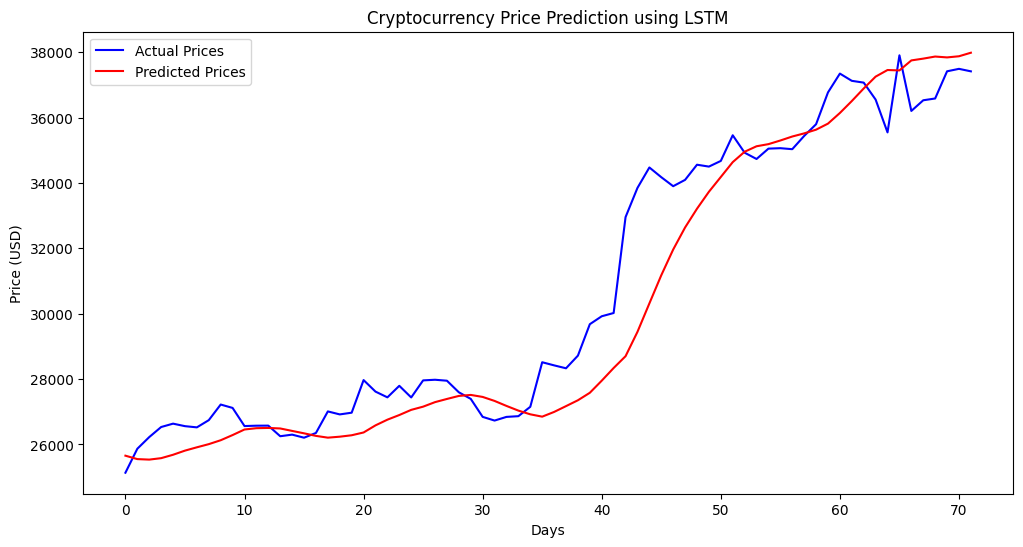

1/1 [==============================] - 0s 21ms/step
Predicted Price for the Next Day: 38100.5625 USD


In [70]:
def main():
    symbol = 'bitcoin'
    days = 365
    timestamps, values = get_historical_data(symbol, days)

    values_scaled, scaler = preprocess_data(values)

    sequence_length = 10
    sequences = create_sequences(values_scaled, sequence_length)

    X = sequences[:, :-1]
    y = sequences[:, -1]

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split data into training and testing sets
    split_ratio = 0.8
    split_index = int(split_ratio * len(sequences))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Build and train the LSTM model
    model = build_lstm_model(sequence_length)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    train_lstm_model(model, X_train, y_train, epochs=10, batch_size=32)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    mse = np.mean(np.square(y_test - y_pred))
    print(f"Mean Squared Error: {mse}")

    # Plot the results
    plot_results(y_test, y_pred, scaler)

    # Predict the next day's price
    last_sequence = values_scaled[-sequence_length + 1:]
    last_sequence = np.reshape(last_sequence, (1, sequence_length - 1, 1))
    next_day_prediction = model.predict(last_sequence)

    # Inverse transform the scaled prediction to get the actual price
    next_day_price = scaler.inverse_transform(next_day_prediction.reshape(-1, 1))
    print(f"Predicted Price for the Next Day: {next_day_price[0][0]} USD")
    return next_day_price[0][0] 

if __name__ == "__main__":
    next_day_price = main()